In this project, I will build a model to make a prediction of NYC Airbnb Rental Prices based on the data provided and any external dataset(s) with relevant information. As of August 2019, this data set contains almost 50 thousand airbnb listings in NYC. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('AB_NYC_2019.csv')

I drop unnecessary field to make a prediction.

In [2]:
df.drop(["id", "name", "host_id", "host_name", "last_review"], axis = 1, inplace = True)
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

As we can see that in the reviews_per_month field, there are some missing values. 
- numberofreview: represents the total reviews given to specific id
- lastreview: represents the most recent review's date.
- reviewsper_month: represents the reviews given to a specific id in a month.

In [3]:
df["reviews_per_month"].replace(np.nan , 0, inplace = True)

Because we want to predict the rental prices of Airbnb, intuitively we want to know correlation between variable price and the other predictor variable.

In [4]:
df.corr()["price"].sort_values()

longitude                        -0.150019
reviews_per_month                -0.050564
number_of_reviews                -0.047954
latitude                          0.033939
minimum_nights                    0.042799
calculated_host_listings_count    0.057472
availability_365                  0.081829
price                             1.000000
Name: price, dtype: float64

We see that the correlation among the other variables are not significant, either positive or negative correlation, it's close to zero. This is indicate that Linear Regression with one or two predictor is not suitable to make a pricing. <br> If we make histogram of price distribution, we can see the distribution is skewed to the right. It's nice if we can do a transformation so the distribution is close to normal. I try to do a log transformation on price data.

<AxesSubplot:xlabel='price'>

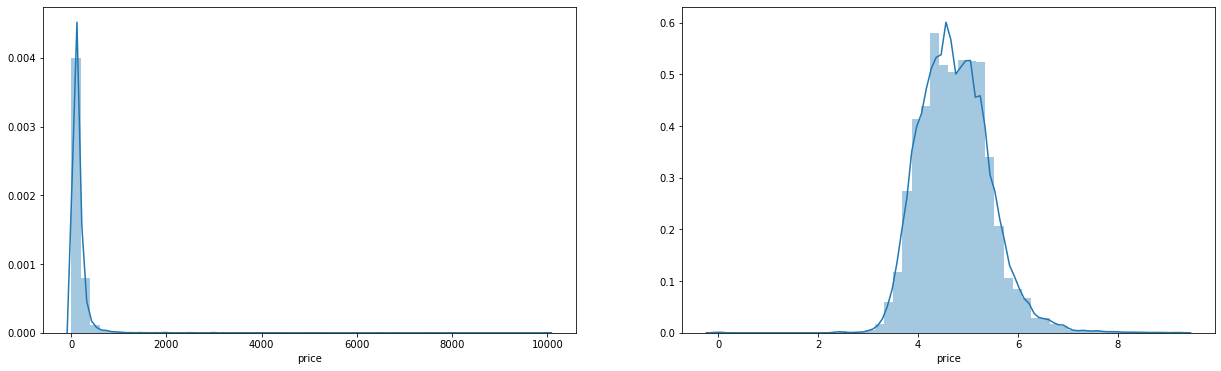

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (21, 6))
sns.distplot(df["price"], ax = axes[0])
sns.distplot(np.log1p(df["price"]), ax = axes[1])

From those picture, on the left is the original price data and on the right is price data after transformation. We can see the histogram after we applied log transformation is close to normal distribution. <br>
Next step is we made a dummies variable to present categorical data into numerical data such as room_type, neighbourhood_group, and neighbourhood field, using one-hot-encoding.

In [6]:
df_dummies1 = pd.get_dummies(df, columns = ['room_type'])
df_dummies2 = pd.get_dummies(df_dummies1, columns = ['neighbourhood_group'])
df_dummies3 = pd.get_dummies(df_dummies2, columns = ['neighbourhood'])
from sklearn.model_selection import train_test_split

In [7]:
df_dummies3.shape

(48895, 237)

Now, it's the part for building the model. I try several models and looking for the best accuracy in R-square based on cross validation. At first, I use Ridge Regression to predict the price with parameter alpha = 0.1.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
X = df_dummies3.drop(['price'], axis = 1).values
y = df_dummies3['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
y_train_log = np.log(y_train + 1)
y_test_log = np.log(y_test + 1)
y_log = np.log(y + 1)
ridge = Ridge(alpha = 0.1)
scores = cross_val_score(ridge, X, y_log, cv = 3)
scores

array([0.47887956, 0.50950195, 0.52890537])

Then, we compare the result between Ridge and Lasso with parameter alpha = 0.0001.

In [9]:
from sklearn.linear_model import Lasso
X = df_dummies3.drop(['price'], axis = 1).values
y = df_dummies3['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
y_train_log = np.log(y_train + 1)
y_test_log = np.log(y_test + 1)
y_log = np.log(y + 1)
lasso = Lasso(alpha = 0.0001)
scores = cross_val_score(lasso, X, y_log, cv = 3)
scores

array([0.47720119, 0.50961282, 0.53177234])

Ridge regression is usually the first choice between Linear Regression and Lasso model. However, if you have a large amount of features and expect only a few of them to be important, Lasso might be a better choice. Similarly, if you would like to have a model that is easy to interpret, Lasso will provide a model that is easier to understand, as it will select only a subset of the input features. <br>
Now, we will try another model, which is a trees with Random Forest Regressor to predict the prices.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 350, random_state = 0)
X = df_dummies3.drop(['price'], axis = 1).values
y = df_dummies3['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
y_train_log = np.log(y_train + 1)
y_test_log = np.log(y_test + 1)
y_log = np.log(y + 1)
scores = cross_val_score(forest, X, y_log, cv = 3)
scores

array([0.5158481 , 0.55120776, 0.55642811])

Generally, if we compare between that three models, the best accuracy is predicting prices with Random Forest Regressor. But, the higher value of n_estimators parameter, the longer computing time to predict the price. The idea of random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data.